In [98]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# import model and fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gmaps
import gmaps.datasets

Populating the interactive namespace from numpy and matplotlib


/opt/miniconda3/envs/metis/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [99]:
#load the data collected by web scraping
airbnb1=pd.read_csv('/Users/jsong/Documents/Airbnb/df_ny.csv')
airbnb1

,name,price,OCrate,neighbor,property_type,bed,bath
0,Classic NYC loft apt in brownstone,$129/night,81%,Harlem,Apartment,2.0,1.0
1,Modern 1 bedroom 5min Cental Park,$173/night,89%,Upper West Side,Apartment,2.0,1.0
2,Madison Avenue Studio Suite (2),$104/night,66%,Sutton Place,Apartment,2.0,1.0
3,Madison Avenue 1 Bedroom Suite,$110/night,91%,Sutton Place,Apartment,2.0,1.0
4,Madison Avenue 3 Room Loft,$140/night,57%,Midtown,Apartment,3.0,1.0
...,...,...,...,...,...,...,...
8782,Cozy fully furnished one bedroom,$163/night,14%,Washington Heights,Apartment,1.0,1.0
8783,Charming Apt. In Brooklyn Townhouse,$135/night,53%,Bushwick,Apartment,2.0,1.0
8784,New and modern NYC home,$150/night,29%,Port Morris,Apartment,1.0,1.0
8785,Cozy two bedroom apartment,$161/night,95%,Sutton Place,Apartment,2.0,1.0


In [100]:
#data clearing
airbnb1['price'] = airbnb1['price'].str.replace('$', '')
airbnb1['price'] = airbnb1['price'].str.replace('/night', '')
airbnb1['price'] = airbnb1['price'].str.replace(',', '')
airbnb1['OCrate'] = airbnb1['OCrate'].str.replace('%', '')
airbnb1['OCrate'] = airbnb1['OCrate'].str.replace(' ', '')
airbnb1['neighbor'] = airbnb1['neighbor'].str.rstrip()
del airbnb1['name']
airbnb1.rename(columns={'price': 'Price/Night', 'OCrate':'Occupancy_Rate', 'neighbor':'Neighbor', \
                        'property_type':'Property_Type', 'bed':'Bed', 'bath':'Bath'}, inplace=True)

In [101]:
airbnb1['Price/Night'] = airbnb1['Price/Night'].astype(int)

In [102]:
airbnb1['Occupancy_Rate'] = pd.to_numeric(airbnb1['Occupancy_Rate'], errors='coerce')
airbnb1.dropna(subset=["Occupancy_Rate"], inplace=True)
airbnb1['Occupancy_Rate'] = airbnb1['Occupancy_Rate'].astype(int)

In [103]:
airbnb1

,Price/Night,Occupancy_Rate,Neighbor,Property_Type,Bed,Bath
0,129,81,Harlem,Apartment,2.0,1.0
1,173,89,Upper West Side,Apartment,2.0,1.0
2,104,66,Sutton Place,Apartment,2.0,1.0
3,110,91,Sutton Place,Apartment,2.0,1.0
4,140,57,Midtown,Apartment,3.0,1.0
...,...,...,...,...,...,...
8782,163,14,Washington Heights,Apartment,1.0,1.0
8783,135,53,Bushwick,Apartment,2.0,1.0
8784,150,29,Port Morris,Apartment,1.0,1.0
8785,161,95,Sutton Place,Apartment,2.0,1.0


In [104]:
airbnb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8687 entries, 0 to 8786
Data columns (total 6 columns):
Price/Night       8687 non-null int64
Occupancy_Rate    8687 non-null int64
Neighbor          8687 non-null object
Property_Type     8687 non-null object
Bed               8426 non-null float64
Bath              8681 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 475.1+ KB


In [105]:
airbnb1 = airbnb1.loc[airbnb1['Price/Night'] <= 1500, :]
airbnb1 = airbnb1.loc[airbnb1['Bed'] <= 10, :]
airbnb1 = airbnb1.loc[airbnb1['Bath'] <= 5, :]

In [106]:
neighbor=pd.read_csv('/Users/jsong/Documents/Airbnb/neighbor_list.csv')
neighbor

,neighbourhood_group,neighbourhood,latitude,longitude
0,Bronx,Allerton,40.865292,-73.858727
1,Bronx,Baychester,40.873616,-73.842967
2,Bronx,Belmont,40.855062,-73.887109
3,Bronx,Bronxdale,40.854731,-73.866287
4,Bronx,Castle Hill,40.816889,-73.847000
...,...,...,...,...
264,Queens,Clearview,40.780500,-73.797800
265,Queens,Floral park,40.733500,-73.712100
266,Staten Island,Bulls Head,40.607200,-74.162400
267,Queens,Oakland Gardens,40.740900,-73.758200


In [107]:
neighbor.rename(columns={'neighbourhood_group': 'Boroughs', 'latitude':'Latitude', 'longitude':'Longitude'}, inplace=True)

In [108]:
airbnb2 = airbnb1.merge(neighbor,how='left', left_on='Neighbor', right_on='neighbourhood')
del airbnb2['neighbourhood']
airbnb2

,Price/Night,Occupancy_Rate,Neighbor,Property_Type,Bed,Bath,Boroughs,Latitude,Longitude
0,129,81,Harlem,Apartment,2.0,1.0,Manhattan,40.816026,-73.948006
1,173,89,Upper West Side,Apartment,2.0,1.0,Manhattan,40.788463,-73.973735
2,104,66,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700
3,110,91,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700
4,140,57,Midtown,Apartment,3.0,1.0,Manhattan,40.754871,-73.975820
...,...,...,...,...,...,...,...,...,...
8399,163,14,Washington Heights,Apartment,1.0,1.0,Manhattan,40.844495,-73.938361
8400,135,53,Bushwick,Apartment,2.0,1.0,Brooklyn,40.696741,-73.920373
8401,150,29,Port Morris,Apartment,1.0,1.0,Bronx,40.806734,-73.926620
8402,161,95,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700


In [109]:
airbnb3=airbnb2.dropna()
airbnb3

,Price/Night,Occupancy_Rate,Neighbor,Property_Type,Bed,Bath,Boroughs,Latitude,Longitude
0,129,81,Harlem,Apartment,2.0,1.0,Manhattan,40.816026,-73.948006
1,173,89,Upper West Side,Apartment,2.0,1.0,Manhattan,40.788463,-73.973735
2,104,66,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700
3,110,91,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700
4,140,57,Midtown,Apartment,3.0,1.0,Manhattan,40.754871,-73.975820
...,...,...,...,...,...,...,...,...,...
8399,163,14,Washington Heights,Apartment,1.0,1.0,Manhattan,40.844495,-73.938361
8400,135,53,Bushwick,Apartment,2.0,1.0,Brooklyn,40.696741,-73.920373
8401,150,29,Port Morris,Apartment,1.0,1.0,Bronx,40.806734,-73.926620
8402,161,95,Sutton Place,Apartment,2.0,1.0,Manhattan,40.757600,-73.961700


In [110]:
dummy1=pd.get_dummies(airbnb3['Boroughs'], drop_first=True)
dummy2=pd.get_dummies(airbnb3['Property_Type'], drop_first=True)
airbnb4=pd.concat([airbnb3, dummy1, dummy2], axis=1)
del airbnb4['Boroughs']
del airbnb4['Neighbor']
del airbnb4['Property_Type']

In [111]:
airbnb4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8266 entries, 0 to 8403
Data columns (total 22 columns):
Price/Night           8266 non-null int64
Occupancy_Rate        8266 non-null int64
Bed                   8266 non-null float64
Bath                  8266 non-null float64
Latitude              8266 non-null float64
Longitude             8266 non-null float64
Brooklyn              8266 non-null uint8
Manhattan             8266 non-null uint8
Queens                8266 non-null uint8
Staten Island         8266 non-null uint8
Bungalow              8266 non-null uint8
Condominium           8266 non-null uint8
Cottage               8266 non-null uint8
Guest suite           8266 non-null uint8
Guesthouse            8266 non-null uint8
House                 8266 non-null uint8
Loft                  8266 non-null uint8
Other                 8266 non-null uint8
Serviced apartment    8266 non-null uint8
Tiny house            8266 non-null uint8
Townhouse             8266 non-null uint8
Vil

In [112]:
smaller_airbnb= airbnb4.loc[:,['Price/Night', 'Occupancy_Rate', 'Bed', 'Bath', 'Latitude',
                              'Longitude', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']]

In [113]:
smaller_airbnb['Price/Night_log'] = np.log(smaller_airbnb['Price/Night'])
smaller_airbnb

,Price/Night,Occupancy_Rate,Bed,Bath,Latitude,Longitude,Brooklyn,Manhattan,Queens,Staten Island,Price/Night_log
0,129,81,2.0,1.0,40.816026,-73.948006,0,1,0,0,4.859812
1,173,89,2.0,1.0,40.788463,-73.973735,0,1,0,0,5.153292
2,104,66,2.0,1.0,40.757600,-73.961700,0,1,0,0,4.644391
3,110,91,2.0,1.0,40.757600,-73.961700,0,1,0,0,4.700480
4,140,57,3.0,1.0,40.754871,-73.975820,0,1,0,0,4.941642
...,...,...,...,...,...,...,...,...,...,...,...
8399,163,14,1.0,1.0,40.844495,-73.938361,0,1,0,0,5.093750
8400,135,53,2.0,1.0,40.696741,-73.920373,1,0,0,0,4.905275
8401,150,29,1.0,1.0,40.806734,-73.926620,0,0,0,0,5.010635
8402,161,95,2.0,1.0,40.757600,-73.961700,0,1,0,0,5.081404


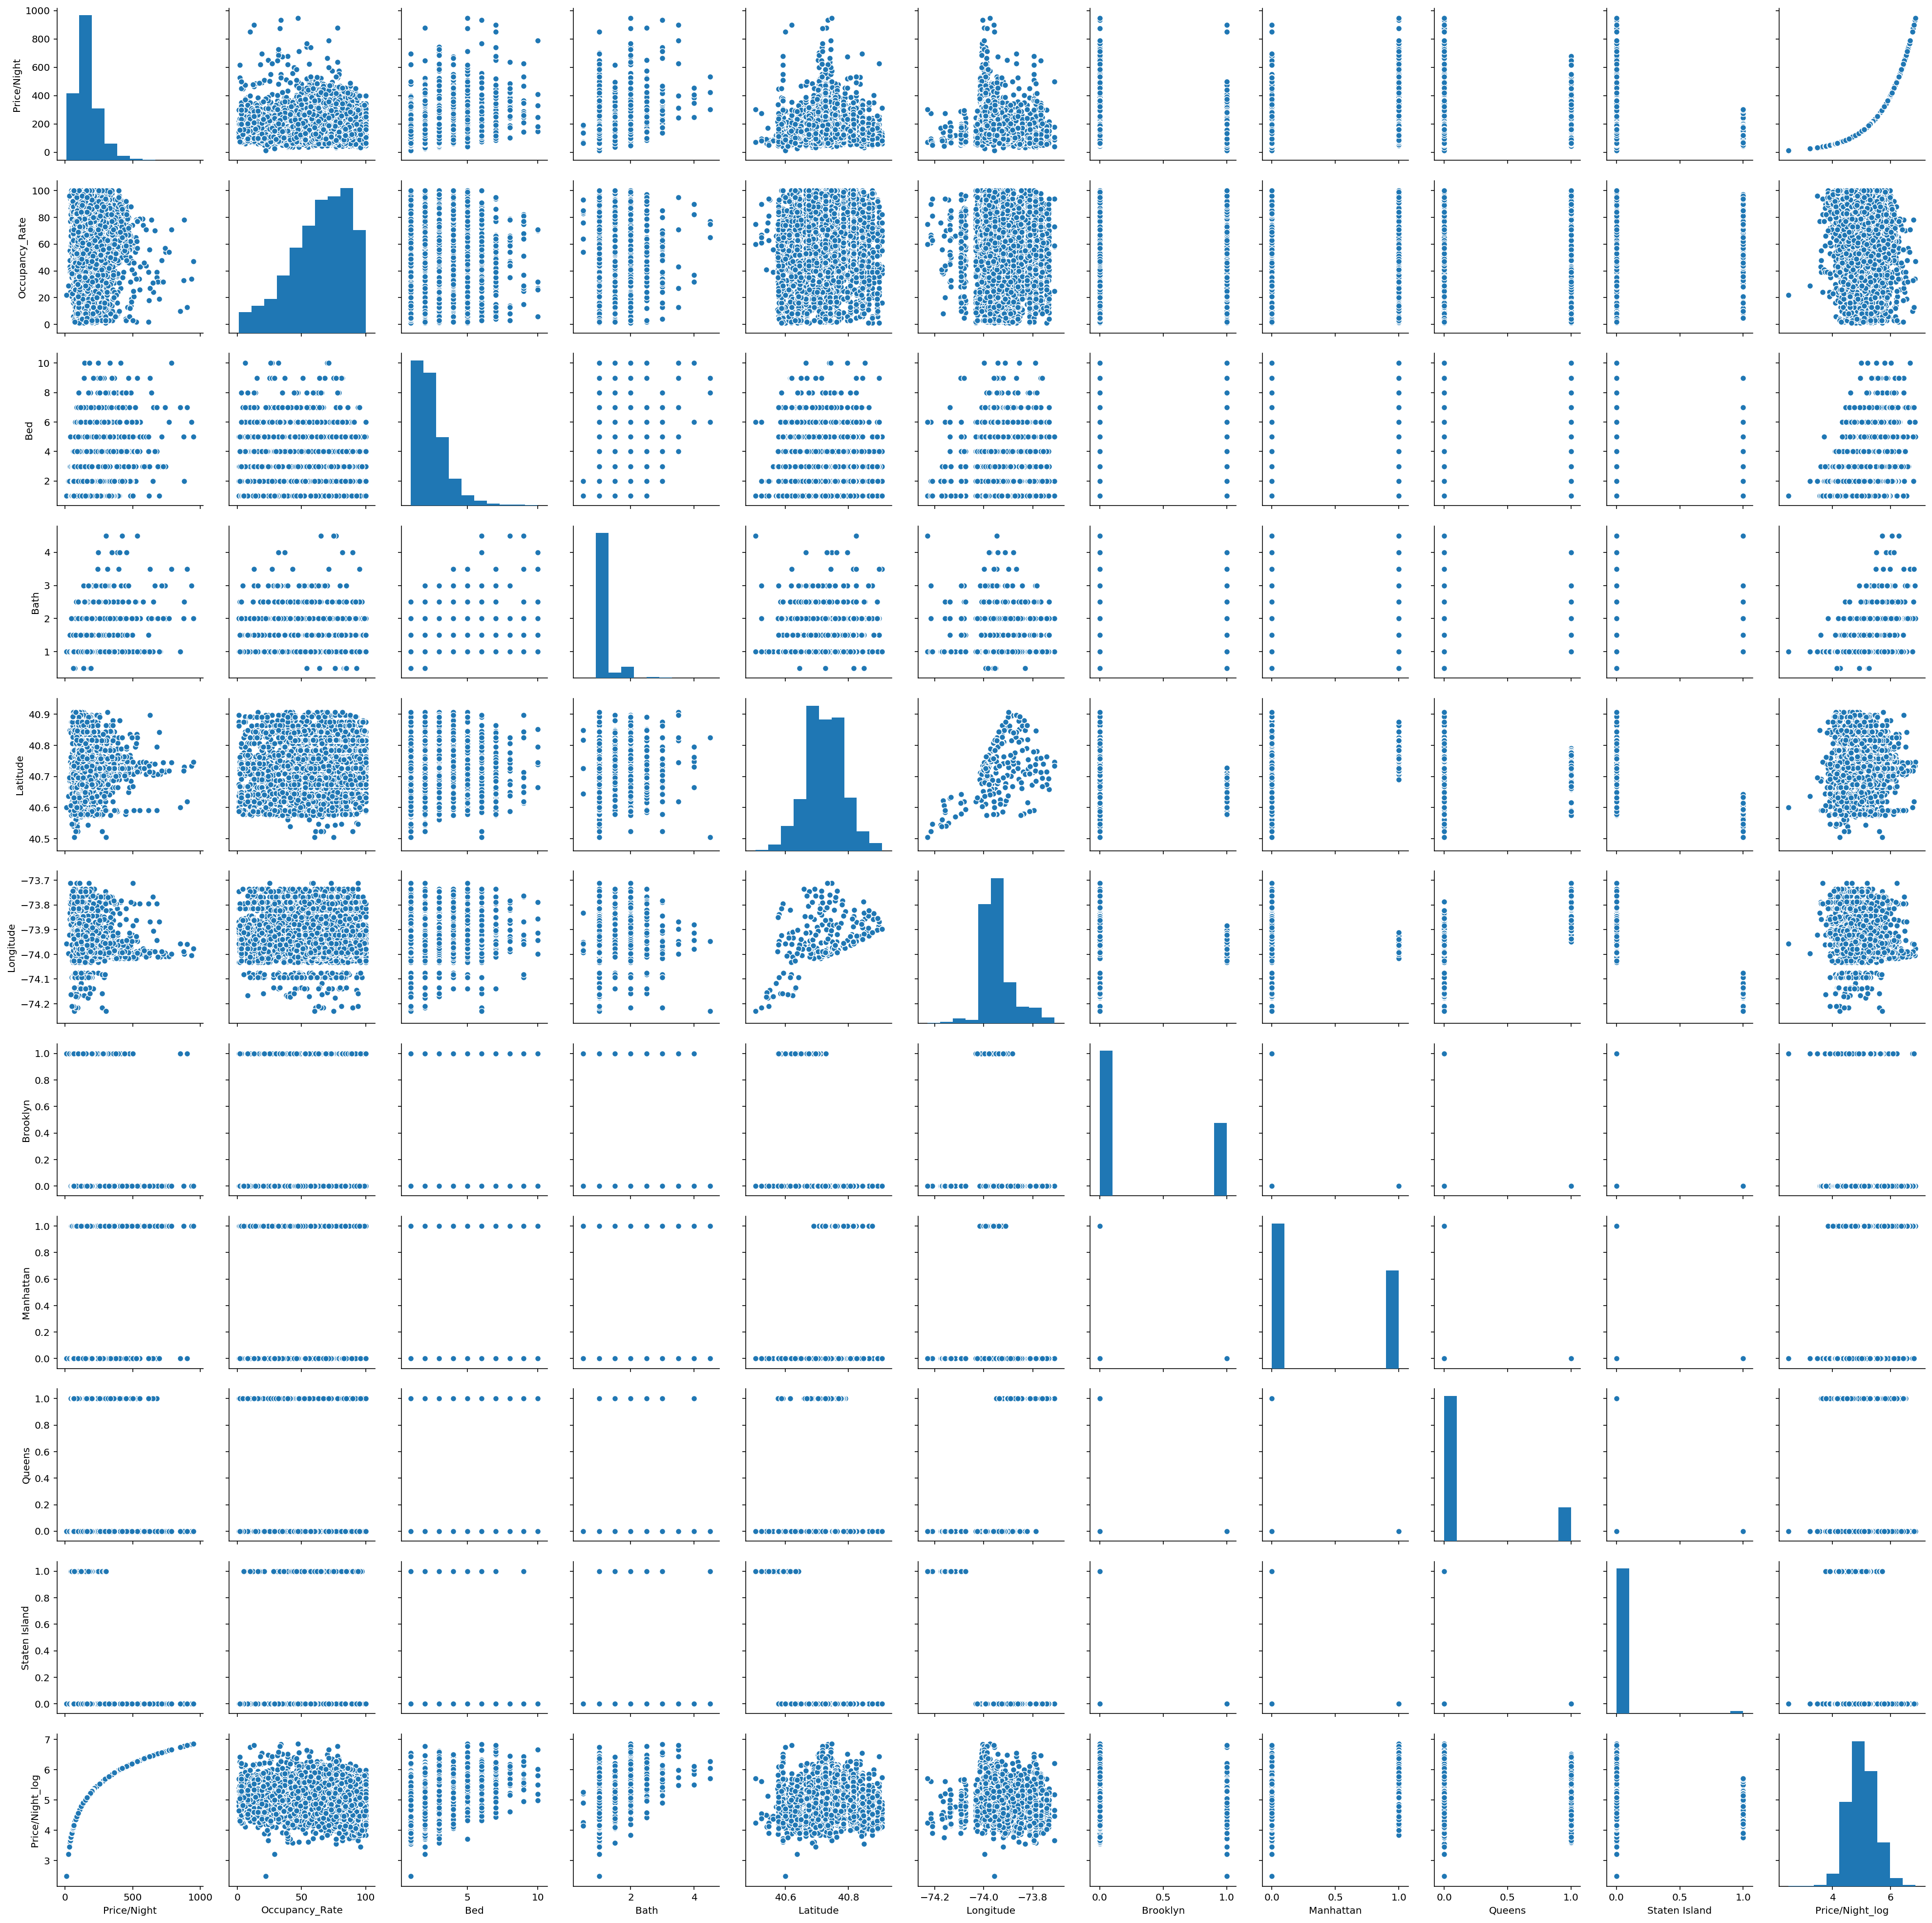

In [17]:
sns.pairplot(smaller_airbnb)

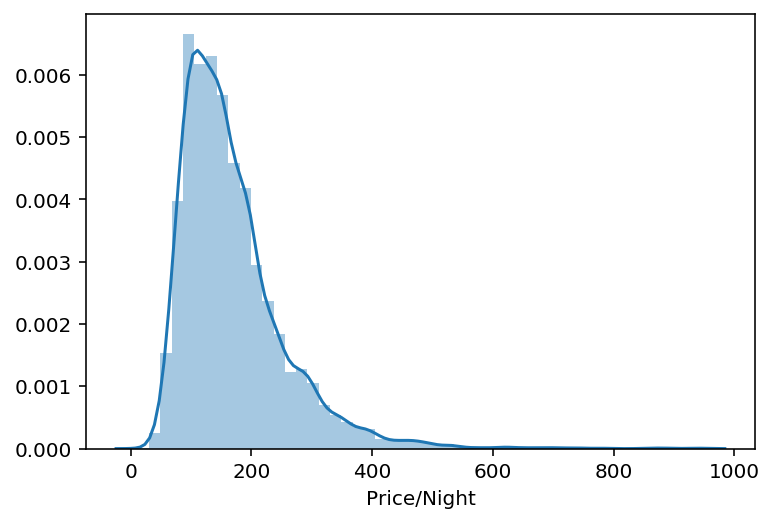

In [114]:
sns.distplot(smaller_airbnb['Price/Night']);

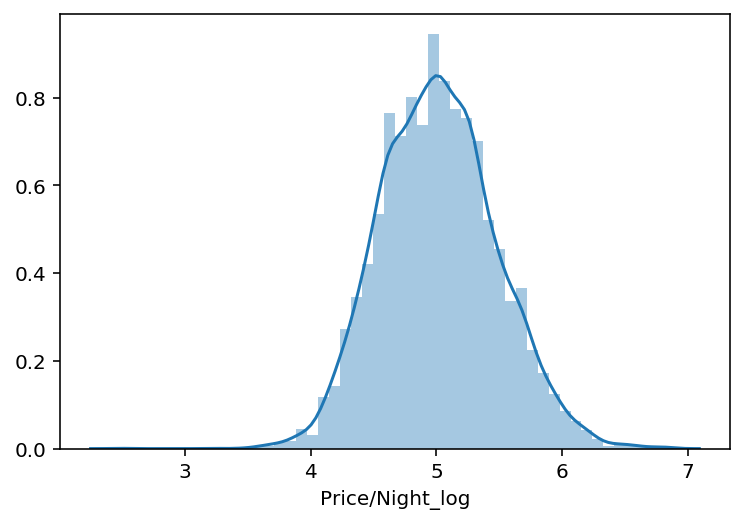

In [115]:
sns.distplot(smaller_airbnb['Price/Night_log']);

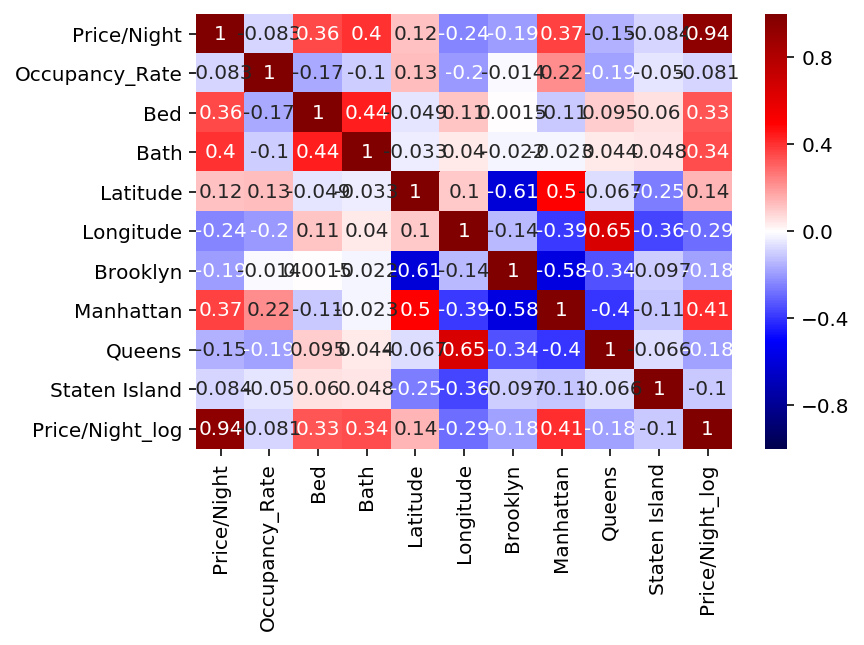

In [18]:
sns.heatmap(smaller_airbnb.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [44]:
#Separate our features from our target

X = smaller_airbnb.loc[:,['Bed', 'Bath', 'Manhattan']]

y = smaller_airbnb['Price/Night']

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8266 entries, 0 to 8403
Data columns (total 3 columns):
Bed          8266 non-null float64
Bath         8266 non-null float64
Manhattan    8266 non-null uint8
dtypes: float64(2), uint8(1)
memory usage: 521.8 KB


In [46]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=53)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=55)

In [47]:
selected_columns = ['Bed', 'Bath', 'Manhattan']

In [48]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

/opt/miniconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price/Night   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     972.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:01:54   Log-Likelihood:                -28105.
No. Observations:                4959   AIC:                         5.622e+04
Df Residuals:                    4955   BIC:                         5.624e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8901      3.497      4.544      0.000       9.035      22.745
Bed           19.5895      0.876     22.351      0.000      17.871      21.308
Bath          73.6329      3.217     22.890      0.000      67.326      79.939
Manhattan     73.6201      2.041     36.064      0.000      69.618      77.622
==============================================================================
Omnibus:                     2013.800   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17549.679
Skew:                           1.705   Prob(JB):                         0.00
Kurtosis:                      11.562   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
skl_model = LinearRegression()
skl_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
skl_model.coef_

array([19.58948232, 73.63286362, 73.62007168])

In [51]:
skl_model.intercept_

15.890091475154634

In [52]:
skl_model.score(X_train, y_train)

0.37064703482628003

In [53]:
skl_model.score(X_val, y_val)

0.36263595404938076

In [54]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=55)

    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')         

In [55]:
X1=X_train_val
y1=y_train_val
split_and_validate(X1, y1)


Validation R^2 score was: 0.35696244270472366
Feature coefficient results: 

Bed : 19.14
Bath : 73.93
Manhattan : 73.20


In [56]:
X2 = X1.copy()

X2['BD_x_M'] = X2['Bed'] * X2['Manhattan']
X2['BTH_x_M'] = X2['Bath'] * X2['Manhattan']

split_and_validate(X2, y1)


Validation R^2 score was: 0.3827227819803565
Feature coefficient results: 

Bed : 15.27
Bath : 60.52
Manhattan : 13.57
BD_x_M : 12.98
BTH_x_M : 29.53


In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.355


In [58]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.29004492, 0.32852297, 0.38694165, 0.39640614, 0.29930009])

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.36727225, 0.39859036, 0.37333208, 0.35486048, 0.33693028])

In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.3644707519589409
0.3644713418765834


In [61]:
lr_model_ridge = Ridge(alpha = 1)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Bed', 19.602000689112476),
 ('Bath', 73.48608548268224),
 ('Manhattan', 73.55993062403944)]

In [62]:
lr_model_lasso = Lasso(alpha = 1)
lr_model_lasso.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_lasso.coef_))

[('Bed', 19.86532227966664),
 ('Bath', 64.66248242606753),
 ('Manhattan', 69.40201022701125)]

In [63]:
lasso_test_set_pred = lr_model_lasso.predict(X_test.loc[:,selected_columns])
ridge_test_set_pred = lr_model_ridge.predict(X_test.loc[:,selected_columns])

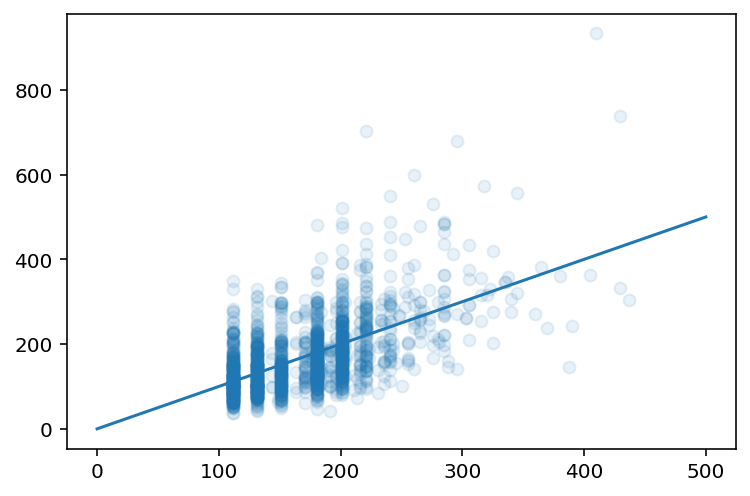

In [95]:
plt.scatter(lasso_test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,500,10), np.linspace(0,500,10))

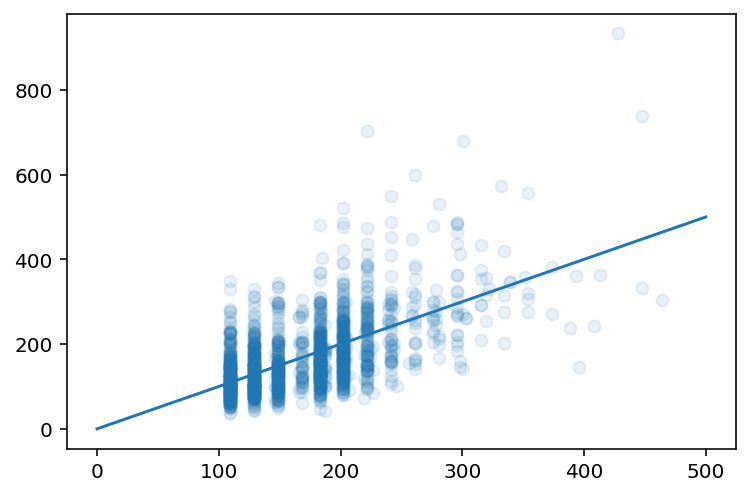

In [67]:
plt.scatter(ridge_test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,500,10), np.linspace(0,500,10))

In [68]:
#lasso r-squared
r2_score(y_test, lasso_test_set_pred)

0.35487025861227917

In [69]:
#ridge r-squared
r2_score(y_test, ridge_test_set_pred)

0.3539352929047761

In [70]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print(mae(y_test, lasso_test_set_pred))
print(mae(y_test, ridge_test_set_pred))

49.74132968296897
49.78954061235536


In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [72]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
X_tr = std.transform(X_train.values)

In [74]:
X_te = std.transform(X_test.values)

In [75]:
type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [76]:
type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

(array([2947.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2012.]),
 array([-0.82627368, -0.62262104, -0.4189684 , -0.21531575, -0.01166311,
         0.19198954,  0.39564218,  0.59929482,  0.80294747,  1.00660011,
         1.21025275]),
 <a list of 10 Patch objects>)

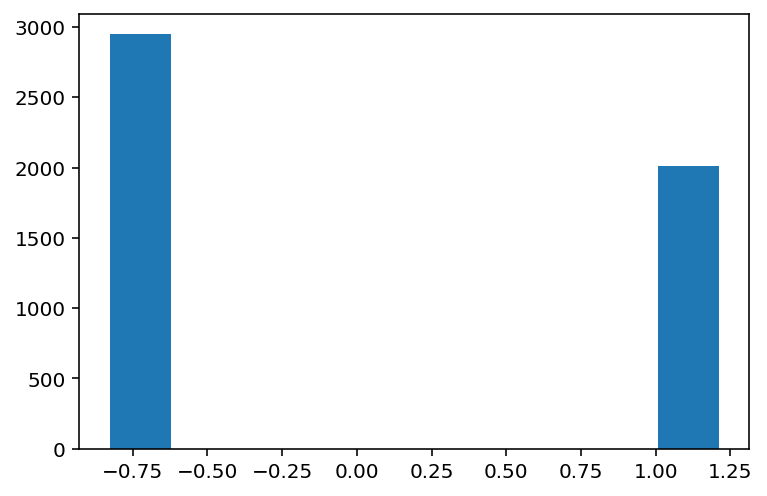

In [77]:
plt.hist(X_tr[:,2])

In [78]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

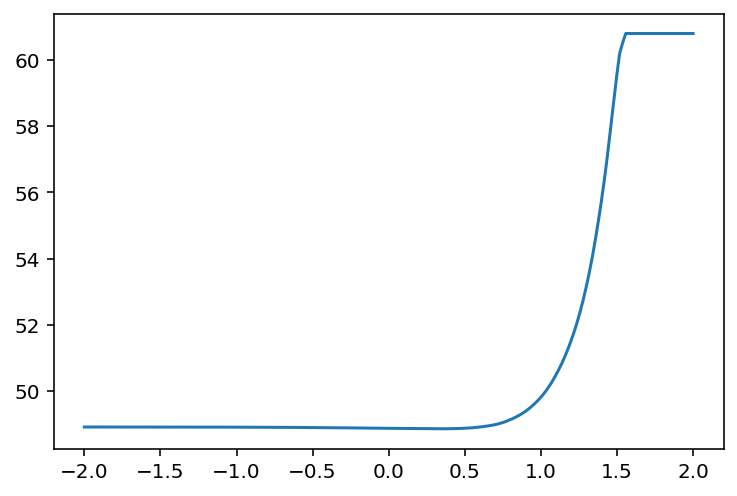

In [79]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [80]:
alphalist[np.argmin(err_vec_val)]

2.049074689815848

In [81]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [82]:
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [83]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [84]:
lasso_model.alpha_

0.08804883581643465

In [85]:
list(zip(X_train.columns, lasso_model.coef_))

[('Bed', 24.964567879462514),
 ('Bath', 25.401740481047543),
 ('Manhattan', 36.05136157535441)]

In [86]:
test_set_pred = lasso_model.predict(X_te)

In [87]:
mae(y_test, test_set_pred)

49.78506240442671

In [88]:
r2_score(y_test, test_set_pred)

0.35401329602230136

In [89]:
gmaps.configure(api_key='*********************')

In [90]:
fig = gmaps.figure(map_type='SATELLITE')
locations = airbnb3[['Latitude', 'Longitude']]
weights = airbnb3['Price/Night']
fig = gmaps.figure()
heatmap_layer=gmaps.heatmap_layer(locations, weights=weights)
fig.add_layer(heatmap_layer)
#heatmap_layer.max_intensity=70
#heatmap_layer.point_radius=2
fig

Figure(layout=FigureLayout(height='420px'))

In [91]:
### features from target
X4 = smaller_airbnb.loc[:,['Bed', 'Manhattan']]
y4 = smaller_airbnb['Price/Night']
print(X4.shape)
print(y4.shape)

(8266, 2)
(8266,)


In [92]:
sm_3d = sm.OLS(y4, X4)
results1 = sm_3d.fit()

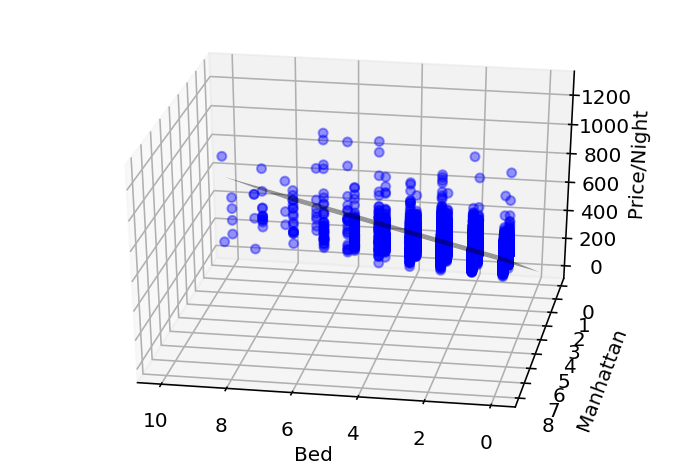

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_surf = np.arange(0, 10, 2) # generate a mesh
y_surf = np.arange(0, 10, 2)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.core.frame.DataFrame({'Bed': x_surf.ravel(), 'Manhattan': y_surf.ravel()})
out = np.array(results1.predict(exog=exog))
ax.plot_surface(x_surf, y_surf,
                out.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

ax.scatter(smaller_airbnb['Bed'], smaller_airbnb['Manhattan'], smaller_airbnb['Price/Night'],
           c='blue',
           marker='o',
           s=20,
           alpha=0.4)

ax.set_xlabel('Bed')
ax.set_ylabel('Manhattan')
ax.set_zlabel('Price/Night')

ax.view_init(azim=100)

plt.show()